# Оценка сходства изображений с использованием сиамской сети с контрастивной функцией потерь
**Дата создания:** 2024/05/08<br>
**Исходник:** https://habr.com/ru/companies/jetinfosystems/articles/465279/<br>
**Описание:** Обучение сиамской сети на созданном наборе данных (85 классов по 14 картинок) с использованием ResNet50, функция потерь - Contrastive Loss<br>
**Примечание:** Картинки в формате JPEG, цветовая модель RGB

##Импорт библиотек

In [1]:
!apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
import os
import shutil
import pathlib
import cv2
import re
import numpy as np
from PIL import Image

In [3]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalMaxPooling2D, Activation
from keras.models import Sequential, Model, load_model
from keras.optimizers import RMSprop
from tensorflow.python.keras.backend import expand_dims
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
from keras.applications import resnet
from keras import regularizers
import random
import matplotlib.pyplot as plt

##Загрузка набора данных для обучения

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
os.chdir('/content')

In [6]:
#!rm -rf "/content/archive_ai"

In [7]:
!unzip -u "/content/drive/MyDrive/archive_ai_0.zip"

Archive:  /content/drive/MyDrive/archive_ai_0.zip
   creating: archive_ai/augmented_image_1/
   creating: archive_ai/augmented_image_10/
   creating: archive_ai/augmented_image_11/
   creating: archive_ai/augmented_image_12/
   creating: archive_ai/augmented_image_13/
   creating: archive_ai/augmented_image_14/
   creating: archive_ai/augmented_image_15/
   creating: archive_ai/augmented_image_16/
   creating: archive_ai/augmented_image_17/
   creating: archive_ai/augmented_image_18/
   creating: archive_ai/augmented_image_19/
   creating: archive_ai/augmented_image_2/
   creating: archive_ai/augmented_image_20/
   creating: archive_ai/augmented_image_21/
   creating: archive_ai/augmented_image_22/
   creating: archive_ai/augmented_image_23/
   creating: archive_ai/augmented_image_24/
   creating: archive_ai/augmented_image_25/
   creating: archive_ai/augmented_image_26/
   creating: archive_ai/augmented_image_27/
   creating: archive_ai/augmented_image_28/
   creating: archive_ai/augm

In [8]:
for i in range(85): #переименование архива
  os.chdir('/content/archive_ai/augmented_image_' + str(i+1)+'/')
  path = pathlib.Path('/content/archive_ai/augmented_image_' + str(i+1)+'/')
  for j, path in enumerate(path.glob('*.jpg')):
    new_name = str(j+1) + '.jpg'
    path.rename(new_name)

##Предобработка картинок для обучения

In [9]:
path = "/content/archive_ai/augmented_image_9/1.jpg"

In [10]:
img = Image.open(path)

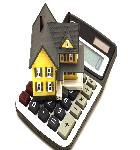

In [11]:
img

In [12]:
img_array = np.array(img)
img_array.shape

(150, 140, 3)

In [13]:
m = img_array[:,:,:]
m.shape

(150, 140, 3)

In [14]:
x = expand_dims(m, axis=0)
x.shape


TensorShape([1, 150, 140, 3])

In [15]:
x = expand_dims(x, axis=0)
x.shape

TensorShape([1, 1, 150, 140, 3])

##Функция генерации данных

In [16]:
def get_data(total_sample_size):

    #считываем изображение
    image = cv2.imread('/content/archive_ai/augmented_image_' + str(1) + '/' + str(1) + '.jpg')

    #получаем новый размер
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0

    #инициализируем массив numpy в форме [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 3, dim1, dim2]) # 2 для пар
    y_genuine = np.zeros([total_sample_size, 1])

    for i in range(85):
        for j in range(int(total_sample_size/85)):
            ind1 = 0
            ind2 = 0

            #чтение изображений из одного каталога (подлинная пара)
            while ind1 == ind2:
                ind1 = np.random.randint(14)
                ind2 = np.random.randint(14)

            #читаем два изображения
            img1 = cv2.imread('/content/archive_ai/augmented_image_' + str(i+1) + '/' + str(ind1 + 1) + '.jpg')
            img1 = img1.reshape(3,150,140)

            img2 = cv2.imread('/content/archive_ai/augmented_image_' + str(i+1) + '/' + str(ind2 + 1) + '.jpg')
            img2 = img2.reshape(3,150,140)

            #сохраняем изображения в инициализированном массиве numpy
            x_geuine_pair[count, 0, :, :, :] = img1
            x_geuine_pair[count, 1, :, :, :] = img2

            #поскольку мы рисуем изображения из того же каталога, мы присваиваем метке значение 1. (подлинная пара)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 3, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])

    for i in range(int(total_sample_size/14)):
        for j in range(14):

            #чтение изображений из другого каталога (пара imposite)
            while True:
                ind1 = np.random.randint(85)
                ind2 = np.random.randint(85)
                if ind1 != ind2:
                    break

            img1 = cv2.imread('/content/archive_ai/augmented_image_' + str(ind1+1) + '/' + str(j + 1) + '.jpg')
            img1 = img2.reshape(3,150,140)

            img2 = cv2.imread('/content/archive_ai/augmented_image_' + str(ind2+1) + '/' + str(j + 1) + '.jpg')
            img2 = img2.reshape(3,150,140)

            x_imposite_pair[count, 0, :, :, :] = img1
            x_imposite_pair[count, 1, :, :, :] = img2
            #поскольку мы рисуем изображения из другого каталога, мы присваиваем метке значение 0. (пара imposite)
            y_imposite[count] = 0
            count += 1

    #объединяем подлинные пары и ложную пару, чтобы получить все данные целиком
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

##Генерация подлинных и ложных пар

In [17]:
total_sample_size = 1190

X, Y = get_data(total_sample_size)


In [18]:
X.shape

(2380, 2, 3, 150, 140)

In [19]:
Y.shape

(2380, 1)

## Создание и обучение нейронной сети


75 % пар пойдет на обучение, а 25 % — на тестирование

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [21]:
x_test.shape

(595, 2, 3, 150, 140)

In [22]:
y_test.shape

(595, 1)

In [23]:
x_train.shape

(1785, 2, 3, 150, 140)

In [24]:
y_train.shape

(1785, 1)

In [25]:
x = expand_dims(m, axis=0)
x.shape


TensorShape([1, 150, 140, 3])

In [26]:
x = expand_dims(x, axis=0)
x.shape


TensorShape([1, 1, 150, 140, 3])

Определим базовую сеть — это будет свёрточная нейросеть для извлечения свойств

In [27]:
def build_base_network(input_shape):
    seq = Sequential()

    base_cnn = resnet.ResNet50(
        weights="imagenet", input_shape=input_shape, include_top=False,
    )
    seq.add(base_cnn)

    seq.add(GlobalMaxPooling2D())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dense(64, activation='relu'))
    seq.add(Dense(32, activation='relu'))

    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable

    return seq

In [28]:
#передадим пару изображений базовой сети, которая вернёт векторные представления, то есть векторы свойств

# Преобразование размерности входных изображений
input_dim = (150, 140, 3)

img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

94765736/94765736 [==============================] - 5s 0us/step


In [29]:
input_dim

(150, 140, 3)

feat_vecs_a и feat_vecs_b — это векторы свойств пары изображений, передадим их функции энергии для вычисления дистанции между ними. А в качестве функции энергии воспользуемся евклидовым расстоянием:

In [30]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [31]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

##Обучение сети

Зададим число эпох, применим свойство RMS для оптимизации и объявим модель:

In [32]:
epochs = 40
rms = RMSprop()

model = Model(inputs=[img_a, img_b], outputs=distance)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 140, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 150, 140, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32)                   2386032   ['input_1[0][0]',             
                                                          0          'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['sequential[0][0]',      

Определим функцию потерь contrastive_loss function и скомпилируем модель:

In [34]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


In [35]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() <  0.52203].mean()

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred <  0.52203, y_true.dtype)))

In [36]:
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

In [37]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1]


In [38]:
img_1 = img_1.reshape(img_1.shape[0], 150, 140, 3).astype('float32')
img_2 = img_2.reshape(img_2.shape[0], 150, 140, 3).astype('float32')

In [39]:
x_train.shape

(1785, 2, 3, 150, 140)

In [40]:
print(img_1.shape)
print(img_2.shape)

(1785, 150, 140, 3)
(1785, 150, 140, 3)


In [41]:
max(Y)

array([1.])

In [42]:
history = model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=256, verbose=2, epochs=epochs)

Epoch 1/40
6/6 - 46s - loss: 3.5152 - accuracy: 0.5777 - val_loss: 0.8998 - val_accuracy: 0.5999 - 46s/epoch - 8s/step
Epoch 2/40
6/6 - 6s - loss: 0.2303 - accuracy: 0.6524 - val_loss: 0.3635 - val_accuracy: 0.6194 - 6s/epoch - 965ms/step
Epoch 3/40
6/6 - 7s - loss: 0.1776 - accuracy: 0.7469 - val_loss: 0.3409 - val_accuracy: 0.6398 - 7s/epoch - 1s/step
Epoch 4/40
6/6 - 6s - loss: 0.1688 - accuracy: 0.7771 - val_loss: 0.2460 - val_accuracy: 0.6848 - 6s/epoch - 975ms/step
Epoch 5/40
6/6 - 7s - loss: 0.1817 - accuracy: 0.7551 - val_loss: 0.5151 - val_accuracy: 0.6358 - 7s/epoch - 1s/step
Epoch 6/40
6/6 - 7s - loss: 0.2344 - accuracy: 0.6921 - val_loss: 0.2822 - val_accuracy: 0.6932 - 7s/epoch - 1s/step
Epoch 7/40
6/6 - 6s - loss: 0.1926 - accuracy: 0.7225 - val_loss: 0.2410 - val_accuracy: 0.6442 - 6s/epoch - 1s/step
Epoch 8/40
6/6 - 6s - loss: 0.2327 - accuracy: 0.7135 - val_loss: 0.1698 - val_accuracy: 0.7206 - 6s/epoch - 1s/step
Epoch 9/40
6/6 - 6s - loss: 0.1549 - accuracy: 0.7704 - 

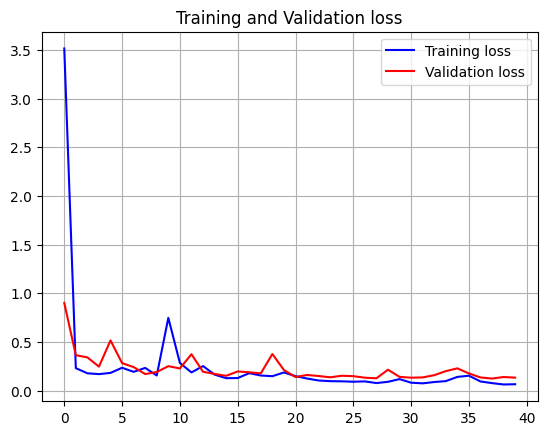

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.grid()
plt.show()

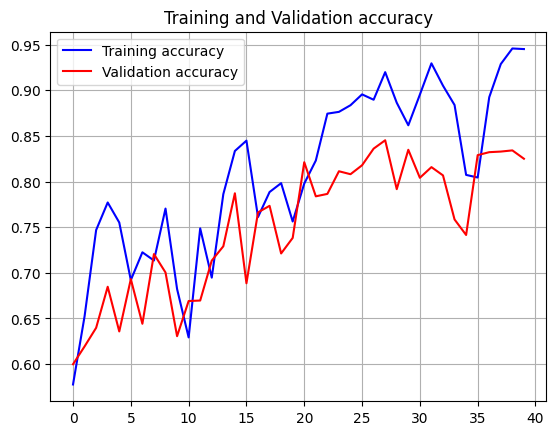

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(acc, 'b', label='Training accuracy')
plt.plot(val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.grid()

In [ ]:
model.save('sinet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
# Получение предсказаний модели на тестовом наборе данных
y_pred = model.predict([np.transpose(x_test[:, 0], (0, 2, 3, 1)), np.transpose(x_test[:, 1], (0, 2, 3, 1))])

19/19 [==============================] - 9s 178ms/step


Best Threshold by maximizing F1 Score: 0.33624804
Best F1 Score: 0.7178807947019868


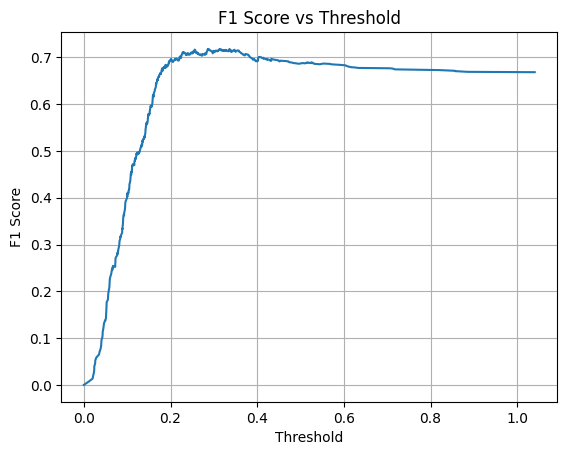

In [46]:
# точность и полнота для различных значений порога
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)

best_f1 = -1
best_threshold = None
f1_scores = []
thresholds_plot = []

# порог, при котором F1-мера максимальна
for i in range(len(thresholds)):
    threshold = thresholds[i]
    y_pred_thresholded = y_pred < threshold
    f1 = f1_score(y_test, y_pred_thresholded)
    f1_scores.append(f1)
    thresholds_plot.append(threshold)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print("Best Threshold by maximizing F1 Score:", best_threshold)
print("Best F1 Score:", best_f1)

# построение графика
plt.plot(thresholds_plot, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid()
plt.show()

In [47]:
x.shape

TensorShape([1, 1, 150, 140, 3])

In [48]:
z = x_test[0, 0]
z.shape

(3, 150, 140)

In [49]:
x = expand_dims(z, axis=1)
x.shape


TensorShape([3, 1, 150, 140])

In [50]:
w = x_test[0, 1]
w.shape

(3, 150, 140)

In [51]:
y = expand_dims(w, axis=1)
y.shape

TensorShape([3, 1, 150, 140])

##Тестирование

In [ ]:
model_new = keras.models.load_model('sinet.h5', compile=False)

In [52]:
target_label = 1
values = np.array(y_test[:,0])

target_index = values.tolist().index(target_label)
print(target_index)
print('target_index value : ',y_test[target_index])

1
target_index value :  [1.]


(150, 140, 3)


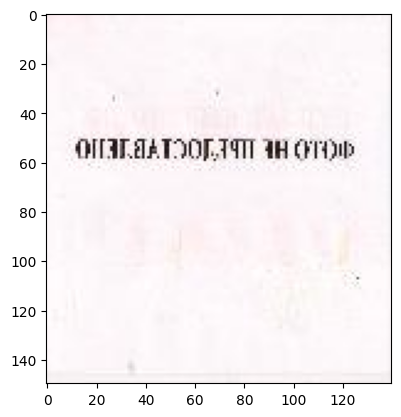

In [53]:
img1 = (x_test[target_index, 0] * 255).astype(np.uint8)
img1 = img1.reshape(150,140,3)
print(img1.shape)
img1
plt.imshow(img1)
plt.show()

(150, 140, 3)


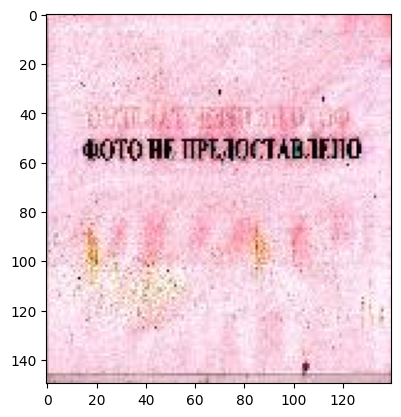

In [54]:
img2 = (x_test[target_index, 1] * 255).astype(np.uint8)
img2 = img2.reshape(150,140,3)
print(img2.shape)
img2
plt.imshow(img2)
plt.show()

In [55]:
x_test[target_index:target_index+1, 0].shape

(1, 3, 150, 140)

In [56]:
pred = model.predict([np.transpose(x_test[target_index:target_index+1, 0], (0, 2, 3, 1)), np.transpose(x_test[target_index:target_index+1, 1], (0, 2, 3, 1))])
print(pred)
pred = pred < best_threshold
print('y_test[target_index]:',y_test[target_index,0]==True,' pred :',pred)

1/1 [==============================] - 2s 2s/step
[[0.17677225]]
y_test[target_index]: True  pred : [[ True]]


In [57]:
target_label = 0
values = np.array(y_test[:,0])

target_index = values.tolist().index(target_label)
print(target_index)
print('target_index value : ',y_test[target_index])

0
target_index value :  [0.]


(150, 140, 3)


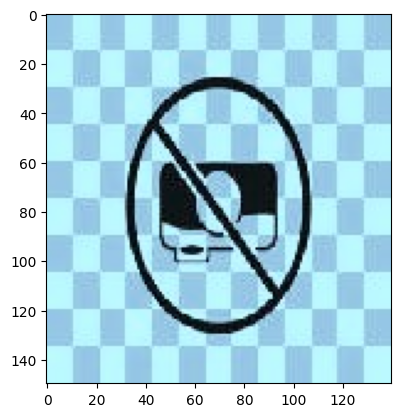

In [58]:
img1 = (x_test[target_index, 0] * 255).astype(np.uint8)
img1 = img1.reshape(150,140,3)
print(img1.shape)
img1
plt.imshow(img1)
plt.show()

(150, 140, 3)


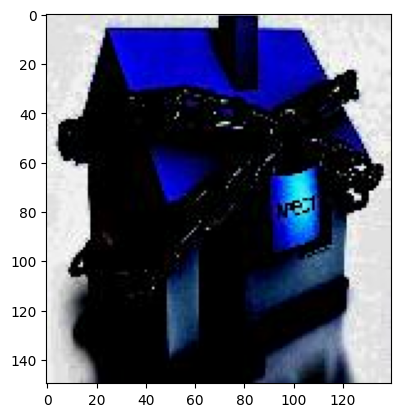

In [59]:
img2 = (x_test[target_index, 1] * 255).astype(np.uint8)
img2 = img2.reshape(150,140,3)
print(img2.shape)
img2
plt.imshow(img2)
plt.show()

In [60]:
x_test[target_index:target_index+1, 0].shape

(1, 3, 150, 140)

In [61]:
pred = model.predict([np.transpose(x_test[target_index:target_index+1, 0], (0, 2, 3, 1)), np.transpose(x_test[target_index:target_index+1, 1], (0, 2, 3, 1))])
print(pred)
pred = pred < best_threshold
print('y_test[target_index]:',y_test[target_index,0]==True,' pred :',pred)

1/1 [==============================] - 0s 49ms/step
[[0.7152034]]
y_test[target_index]: False  pred : [[False]]


In [62]:
y = expand_dims(w, axis=1)
y.shape

TensorShape([3, 1, 150, 140])

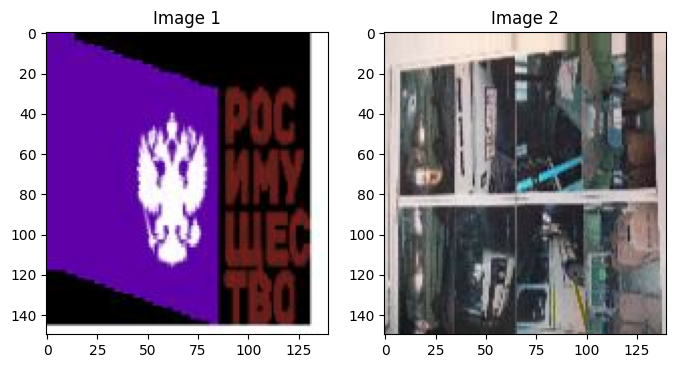

1/1 [==============================] - 0s 48ms/step
Prediction: Картинки не похожи [[0.42750713]]
Actual Label: Картинки не похожи
--------------------------------------------------


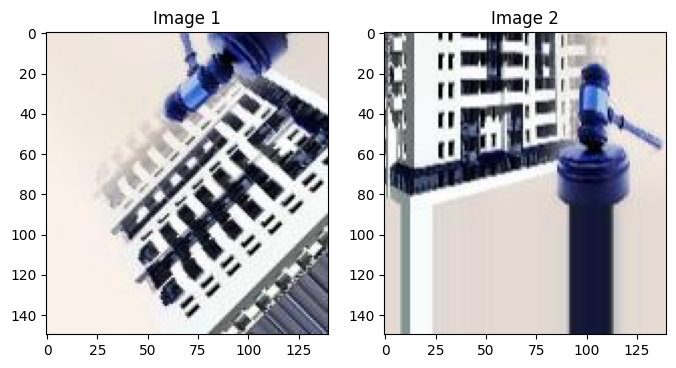

1/1 [==============================] - 0s 62ms/step
Prediction: Картинки похожи [[0.25398764]]
Actual Label: Картинки похожи
--------------------------------------------------


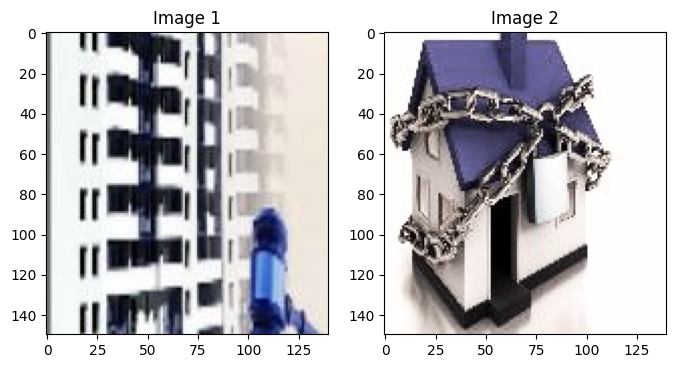

1/1 [==============================] - 0s 53ms/step
Prediction: Картинки не похожи [[0.528523]]
Actual Label: Картинки не похожи
--------------------------------------------------


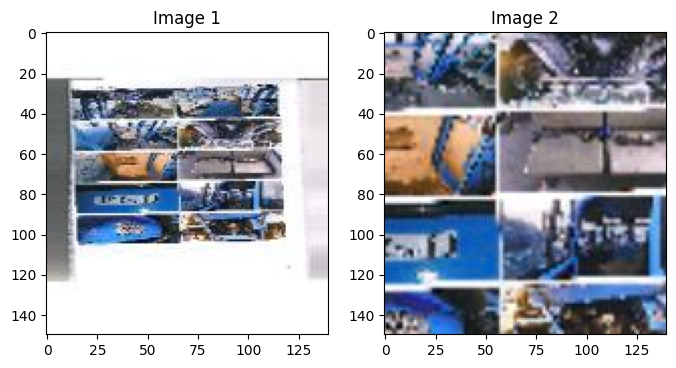

1/1 [==============================] - 0s 64ms/step
Prediction: Картинки похожи [[0.26346558]]
Actual Label: Картинки похожи
--------------------------------------------------


In [63]:
# Определение количества пар картинок, которые вы хотите вывести
num_pairs_to_display = 4

for _ in range(num_pairs_to_display):
    # Генерация случайного индекса
    index = random.randint(0, len(y_test) - 1)

    # Отображение пары картинок
    img1 = (x_test[index, 0] * 255).astype(np.uint8)
    img1 = img1.reshape(150, 140, 3)

    img2 = (x_test[index, 1] * 255).astype(np.uint8)
    img2 = img2.reshape(150, 140, 3)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title('Image 1')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title('Image 2')

    plt.show()

    # Вычисление pred и ответа
    pred = model.predict([np.transpose(x_test[index:index+1, 0], (0, 2, 3, 1)), np.transpose(x_test[index:index+1, 1], (0, 2, 3, 1))])
    pred_label = "Картинки похожи" if pred < best_threshold else "Картинки не похожи"
    print("Prediction:", pred_label,  pred)
    print("Actual Label:", "Картинки похожи" if y_test[index, 0] == True else "Картинки не похожи")
    print("-" * 50)


##Создание интерфейса Gradio

In [81]:
!pip install --upgrade gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 3

In [82]:
import gradio as gr

In [83]:
def resize_image(image):
    if image.shape[:3] != (150, 140, 3):
        image = cv2.resize(image, (140, 150))
    return image

def find_most_similar_image(user_image):
    img = resize_image(user_image)
    # Предобработка загруженного изображения
    img = user_image.reshape((1, 150, 140, 3)).astype('float32') / 255  # Приведение к формату и нормализация

    most_similar_image = None
    most_similar_index = None
    max_similarity = float('inf')
    index = None

    for i in range(len(x_test)):
        # Предобработка изображения из тестового набора данных
        test_image = x_test[i, 0].reshape((1, 150, 140, 3))

        # Предсказание сходства
        pred = model.predict([test_image, img])

        # Если сходство ниже максимального и превышает порог, обновляем наиболее похожее изображение и его индекс
        if pred < max_similarity and pred < best_threshold:
            most_similar_image = x_test[i, 0]
            most_similar_index = i
            max_similarity = pred

    test2 = x_test[most_similar_index, 0].reshape((1, 150, 140, 3))
    pred2 = model.predict([test2, img])

    # Вывод наиболее похожего изображения
    if pred2 < best_threshold:
        print("Наиболее похожее изображение:", pred2)
        plt.imshow(test2.reshape((150, 140, 3)))
        plt.axis('off')
        plt.show()
        return "Наиболее похожее изображение:", pred2, plt

In [84]:
iface = gr.Interface(fn=find_most_similar_image,
                     inputs="image",
                     outputs=["text", "text", "plot"],
                     title="Поиск наиболее похожего изображения",
                     description="Загрузите изображение, чтобы найти наиболее похожее изображение из набора данных.")

iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2abbc8ff3836bf54e0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
